In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,"../src")

In [3]:
import pandas as pd
import numpy as np

from fastai2 import *
from fastai2.text.all import *
import vectorize
import helpers
import transformers
from utils import *
from loss.loss import *

# Load the data

In [4]:
full_df = pd.read_pickle("../data/full_df.pkl")

In [7]:
MAX_VOCAB = None
MAX_SEQ_LENGTH = 5000
full_df['TEXT_PROCESSED'] = vectorize.clean_notes(full_df, 'TEXT')

In [8]:
full_df['ICD9_GRP_LIST'] = full_df.ICD9_GRP.apply(lambda x: re.split(" +", x.strip()))

# Training

Create Item Transformations

In [ ]:
from transformers import BertConfig, BertForSequenceClassification, BertModel, BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
 "bert-base-uncased",
)

fastai_bert_vocab =L(bert_tok.vocab.keys())

In [ ]:
sample_df = full_df.sample(frac=0.3)

In [116]:
item_tfms= [[ColReader('TEXT_PROCESSED'), FastAIBertTokenizer(tokenizer=bert_tok)],
            [ColReader('ICD9_GRP_LIST') , MultiCategorize, OneHotEncode]
           ]

# Create datasource & dataloaders 

splits = RandomSplitter()(range_of(sample_df))
dsrc = Datasets(sample_df, tfms=item_tfms, splits=splits)
dls = dsrc.dataloaders(bs=4)

Testing dataloaders

In [120]:
b = dls.one_batch()

Showing batch

In [121]:
@typedispatch
def show_batch(x, y, samples, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
    
    # samples[0] contains str , samples[1] contains str
    text_samples = []
    label_samples = []
    for i in range_of(samples):
        text_samples.append(samples[i][0][0][300:500])
        actual_labels = [l for l in samples[i][1] if l != ""]
        label_samples.append(actual_labels)
    
    df = pd.DataFrame({'Text': text_samples, 'Label': label_samples})
    display_df(df)

    return ctxs

In [122]:
@typedispatch
def show_results(x, y, samples, outs, ctxs=None, max_n=9, **kwargs):
    if ctxs is None: ctxs = Inf.nones
        
        # samples[0] contains str , samples[1] contains str
    text_samples = []
    label_samples = []
    result_samples = []
    for i in range_of(samples):
        text_samples.append(samples[i][0][0][300:500])
        actual_labels = [l for l in samples[i][1] if l != ""]
        label_samples.append(actual_labels)
        result_samples.append(outs[i][0])
    df = pd.DataFrame({'Text': text_samples, 'Label': label_samples,'Result': result_samples})
    display_df(df)
    
    return ctxs

In [123]:
dls.show_batch(b)

,Text,Label
0,ve procedure left sided thoracentesis history of present illness pt is a dgyo woman with rcc metastatic to lungs with recent progression of disease in the area of the right mainstem bronchus s p mecha,"[140-239, 240-279, 320-389, 390-459, 460-519, 710-739, 800-999]"
1,idua workup revealed a pfo with left to right shunting at rest and right to left with valsalva she was not a candidate for percutaneous closure and is admitted now for closure as she desires more chil,"[710-739, 760-779]"
2,the patient was therefore medflighted to for further care in the emergency room the patient remained hemodynamically stable the patient was noted to have a left wrist deformity as well as ecchymosis,"[001-139, 320-389, 390-459, 580-629, 800-999]"
3,vasive procedure percutaneous cholecystotomy tube history of present illness this is a dg year old nursing home resident admitted from nursing and rehabilitation center with dg day history of abdomina,"[390-459, 520-579, 680-709]"


# Modelling

In [124]:
from models.lstm_attn import *
from models.lstm import *
from loss.loss import *
from fastai2.metrics import *
from transformers import BertModel, BertConfig
from utils import *

In [126]:
V = len(fastai_bert_vocab)
E = 50
C = len(dsrc.tfms[1].vocab)

In [128]:
#load_wordvectors(glove_path)
weights_matrix = get_glove_matrix(glove_path, fastai_bert_vocab, emb_dim=E)

In [129]:
# Loss function
loss_func = ICD_Loss(ignore_index=0)

# Metrics
acc_02 = partial(accuracy_multi, thresh=0.2)
f_score = F1ScoreMulti(thresh=0.2)

# Configuration
config = BertConfig.from_pretrained('bert-base-uncased') 

# Model
#model = BiLSTMWithBertEmbedding(config,V=V, E=E, C=C)
model = SelfAttentionLSTM(V=V, E=E, C=C, weights_matrix=weights_matrix)


Embedding matrix loaded 


In [130]:
learn = Learner(dls, model, loss_func = loss_func, metrics=[acc_02, f_score])

(6.918309736647643e-07, 3.6307804407442745e-07)

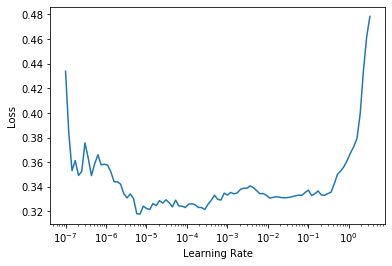

In [135]:
learn.lr_find()

In [132]:
learn.fit_one_cycle(3, lr_max=4*10e-3)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.398279,0.376970,0.713686,0.492942,18:41
1,0.357065,0.352286,0.756227,0.512932,19:35
2,0.345289,0.338804,0.782151,0.530185,19:51


In [134]:
learn.save('3epoch')

In [ ]:
learn.fit_one_cycle(10, lr_max=4*10e-4)
learn.save('10epoch')

epoch,train_loss,valid_loss,accuracy_multi,f1_score,time
0,0.318498,0.337546,0.782292,0.529735,18:06
1,0.332647,0.334545,0.789247,0.535522,17:58


# Show results

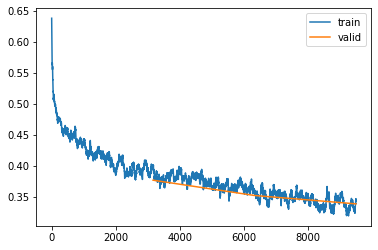

In [133]:
learn.recorder.plot_loss()

In [136]:
learn.show_results()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


,Text,Label,Result
0,he patient is a dg f h o metastatic colon ca recently place on hospice care and s p bilateral nephrostomy tube placement she presented to the ed on with acute onset of r sided flank pain associated wi,"[140-239, 240-279, 460-519, 520-579, 580-629]","[001-139, 140-239, 240-279, 290-319, 320-389, 390-459, 460-519, 520-579, 580-629, 780-789, 800-999]"
1,tn dmdg hyperlipidemia who awoke from sleep at dgam feeling lousy subsequently had dg loose bowel movement then developed substernal chest pressure non radiating no sob diaphoresis he took one full as,"[240-279, 390-459]","[240-279, 290-319, 320-389, 390-459, 580-629]"
2,h spontaneous vaginal delivery in and a spontaneous abortion in maternal past medical history is unremarkable prenatal screens a positive antibody negative hepatitis b negative rpr nonreactive rubella,[760-779],[760-779]
3,ich revealed a reversible apical wall defect and a partially reversible inferior wall defect with an ejection fraction of dg percent he also had an echocardiogram in which revealed an ejection fractio,"[240-279, 390-459]","[240-279, 290-319, 390-459, 580-629, 800-999]"
